In this project, I'm building a predictive model to figure out if a laser is defective or not by looking at its intensity measurements over time. The dataset has time-series data showing how each laser's intensity changes over one minute, with measurements taken every second.

**Problem Type**: This is a **binary classification** problem (supervised learning).

**Input**: Time-series data for each laser, which includes **60 intensity measurements**.

**Output**: A label indicating if the laser is **functioning (1)** or **faulty (-1)**.

**Goal**: Create a model that can accurately predict whether a laser is functioning or faulty based on these measurements.

/Users/yanaarva/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Feature matrix shape: (200, 60)
Label vector shape: (200,)
Missing values in dataset: 0
Class distribution:
-1    100
 1    100
Name: Label, dtype: int64


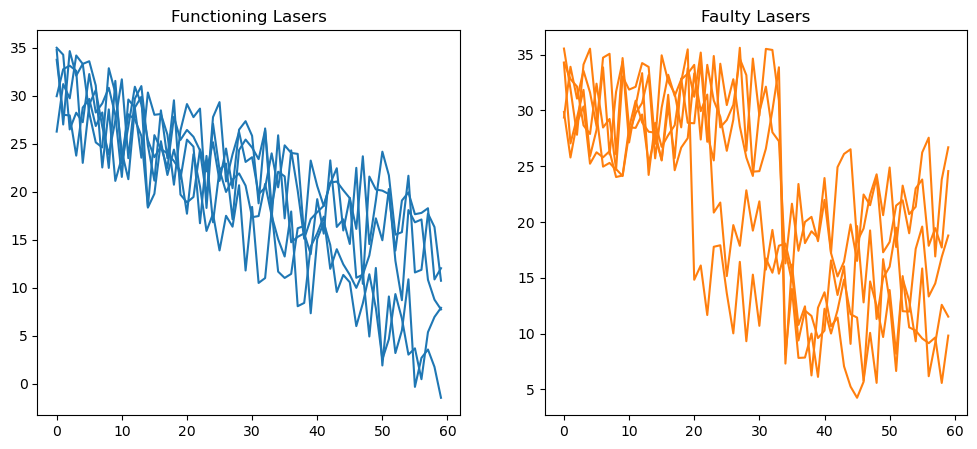

In [1]:
## Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
)
from scipy.io import loadmat
from scipy.stats import skew, kurtosis
from scipy.fft import fft


# exploring the data

# first loading the dataset
data = loadmat("laser.mat")
X = np.array(data['X'])
Y = np.array(data['Y']).reshape(-1)

# then check the shape of the data
print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {Y.shape}")

# convert to DataFrame (for easier manipulation)
df = pd.DataFrame(X)
df['Label'] = Y

# see any missing values
print("Missing values in dataset:", df.isnull().sum().sum())

# class distribution to check for imbalance
print("Class distribution:")
print(df['Label'].value_counts())

# see examples of functioning and faulty lasers
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
neg = X[Y == -1]
pos = X[Y == 1]

# plot the first 5 examples of each class to take a look
for i in range(5):
    ax[0].plot(np.arange(60), pos[i], color='C0')
    ax[1].plot(np.arange(60), neg[i], color='C1')

ax[0].set_title("Functioning Lasers")
ax[1].set_title("Faulty Lasers")
plt.show()

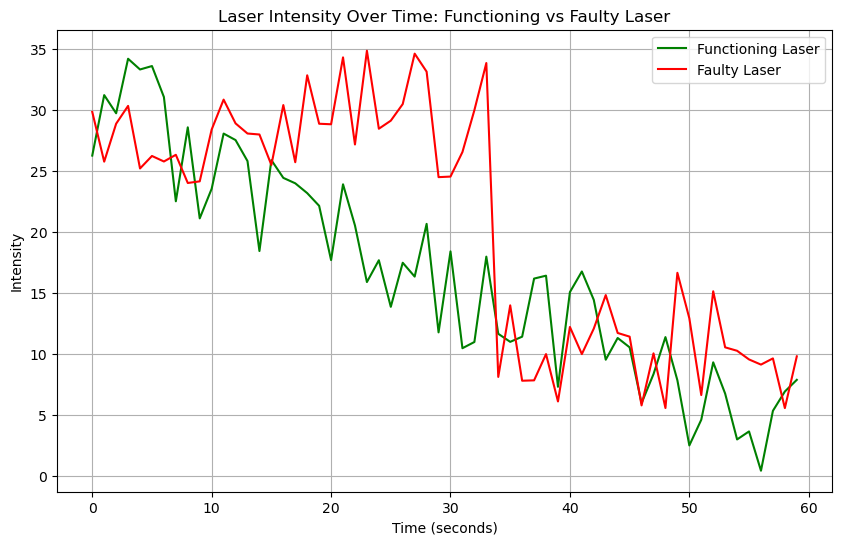

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from scipy.io import loadmat

data = loadmat("laser.mat")
X = np.array(data['X'])  # laser intensity measurements
Y = np.array(data['Y']).reshape(-1)  # labels (-1 for faulty, 1 for functioning)

# time-series plot to represent functioning and faulty lasers
fig, ax = plt.subplots(figsize=(10, 6))

# extract functioning and faulty laser data
functioning_lasers = X[Y == 1]
faulty_lasers = X[Y == -1]

# plot the first functioning and faulty laser
ax.plot(np.arange(60), functioning_lasers[0], label='Functioning Laser', color='green')
ax.plot(np.arange(60), faulty_lasers[0], label='Faulty Laser', color='red')

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Intensity')
ax.set_title('Laser Intensity Over Time: Functioning vs Faulty Laser')
ax.legend()
ax.grid(True)
plt.show()

The functioning laser shows a pretty stable and gradually decreasing intensity, which means it's performing predictably without much fluctuation. On the other hand, the faulty laser has a lot of ups and downs, showing irregular behavior over time. This makes it easier to tell them apart. The plot really helps to highlight these differences, which is useful for our model when trying to classify whether a laser is functioning properly or faulty based on its intensity pattern.

Model Selection

the following models were chosen:

Logistic Regression: Baseline linear model.

Support Vector Machine (SVM): it's effective for binary classification.

Random Forest: Captures non-linear relationships and provides feature importance.

Neural Network (MLP): it can model complex patterns.

In [3]:
# Evaluation Protocol

# Data Splitting: Stratified 5-Fold Cross-Validation.
# Metrics:
# Accuracy
# Precision
# Recall
# F1-Score
# ROC AUC Score
# reasoning: These metrics provide a nice evaluation, especially important if the classes are imbalanced

In [4]:
# Model training and Hyperparameter tuning

# I chose hyperparameter tuning using Grid Search with Cross-Validation

In [5]:
# standardize features to have zero mean and unit variance (to ensure
# that all features contribute equally to the model training)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


# define models and their respective hyperparameters for Grid search
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {'C': [0.01, 0.1, 1, 10]}
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}
    },
    'Neural Network': {
        'model': MLPClassifier(max_iter=1000),
        'params': {'hidden_layer_sizes': [(64,), (128,), (64, 64)], 'activation': ['relu', 'tanh']}
    }
}

# here i define the scorer using F1 score, which balances precision and recall
f1_scorer = make_scorer(f1_score)

best_estimators = {}

# to see Grid Search Cross-Validation for each model to find the best hyperparameters
for model_name, mp in models.items():
    print(f"\nTraining {model_name}...")
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring=f1_scorer, n_jobs=-1)
    clf.fit(X_train, y_train) 
    best_estimators[model_name] = clf.best_estimator_
    print(f"Best parameters for {model_name}: {clf.best_params_}")
    print(f"Best cross-validation F1 score: {clf.best_score_:.4f}")

    from sklearn.model_selection import cross_val_score


Training Logistic Regression...


/Users/yanaarva/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/yanaarva/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/yanaarva/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/yanaarva/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  

Best parameters for Logistic Regression: {'C': 0.01}
Best cross-validation F1 score: 0.9681

Training SVM...
Best parameters for SVM: {'C': 10, 'kernel': 'rbf'}
Best cross-validation F1 score: 0.9935

Training Random Forest...
Best parameters for Random Forest: {'max_depth': 5, 'n_estimators': 50}
Best cross-validation F1 score: 0.9677

Training Neural Network...
Best parameters for Neural Network: {'activation': 'tanh', 'hidden_layer_sizes': (128,)}
Best cross-validation F1 score: 0.9552


In [6]:
# Feature Engineering part

# To capture the characteristics of the intensity fluctuations, 
# I have to extract both statistical and frequency domain features.


Evaluating Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



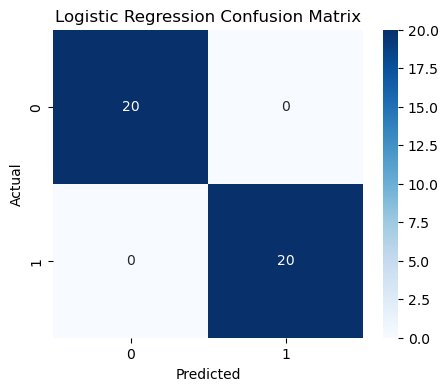

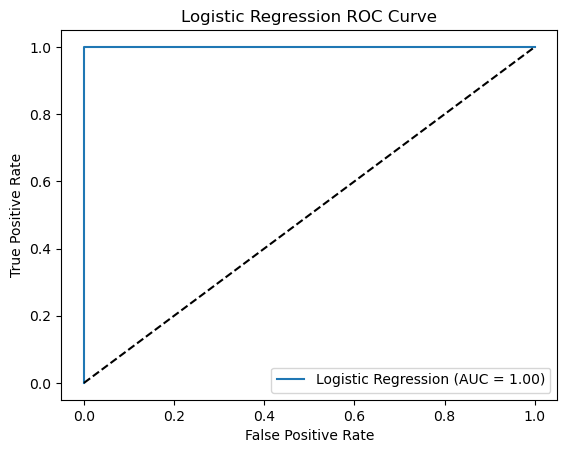

Interpretation for Logistic Regression:
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1 Score: 1.0000
- ROC AUC: 1.0000

Evaluating SVM...
Classification Report for SVM:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



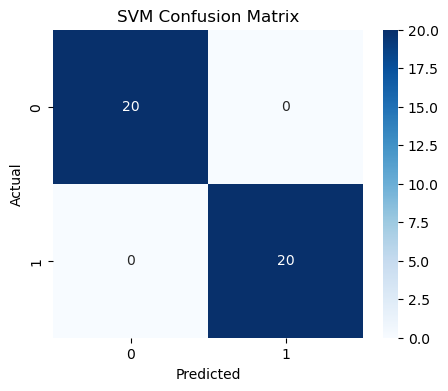

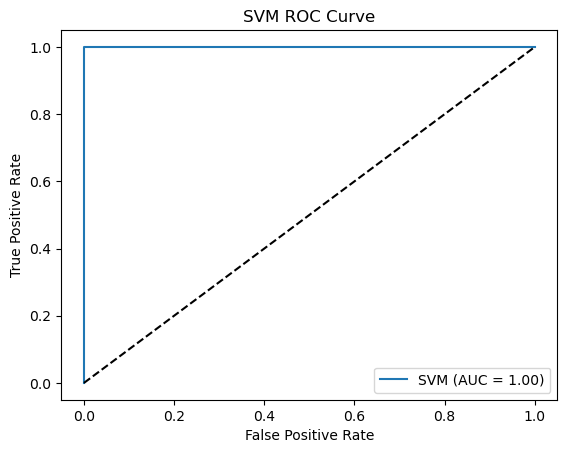

Interpretation for SVM:
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1 Score: 1.0000
- ROC AUC: 1.0000

Evaluating Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

          -1       0.87      1.00      0.93        20
           1       1.00      0.85      0.92        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



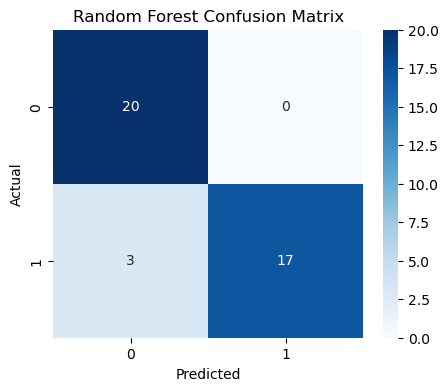

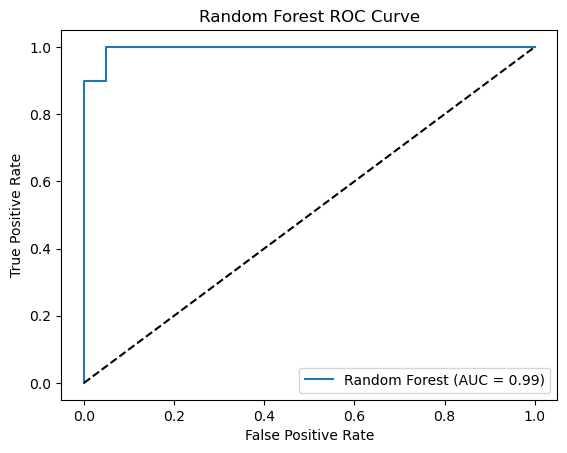

Interpretation for Random Forest:
- Accuracy: 0.9250
- Precision: 1.0000
- Recall: 0.8500
- F1 Score: 0.9189
- ROC AUC: 0.9950

Evaluating Neural Network...
Classification Report for Neural Network:
              precision    recall  f1-score   support

          -1       0.77      0.85      0.81        20
           1       0.83      0.75      0.79        20

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40



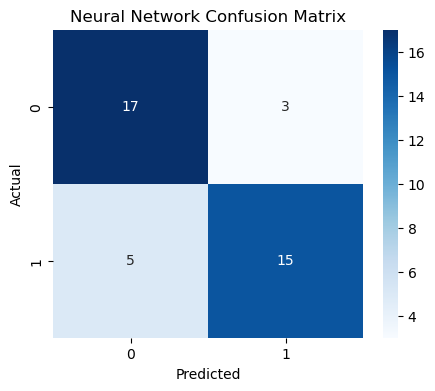

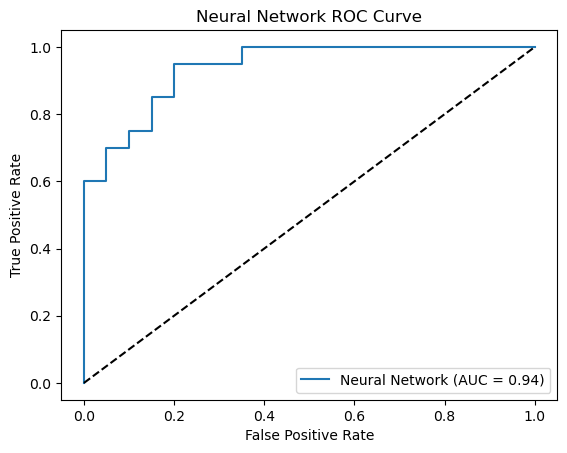

Interpretation for Neural Network:
- Accuracy: 0.8000
- Precision: 0.8333
- Recall: 0.7500
- F1 Score: 0.7895
- ROC AUC: 0.9375


In [7]:
# Model Evaluation and Comparison

# evaluating the models on a hold-out test set.
# Then splitting data into training and testing sets using stratification to make sure that 
# the original dataset and these have the same class distribution


# making a list to store evaluation results
results = []

# evaluating each model on the test set
for model_name, model in best_estimators.items():
    print(f"\nEvaluating {model_name}...")
    y_pred = model.predict(X_test) # predicting labels on test data
    y_proba = model.predict_proba(X_test)[:, 1] # getting probability estimates for ROC curve
    
    # generating a classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    # plotting the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # plotting the ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{model_name} ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
    # calculating evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # attaching the results to the list
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

   # printing the results
    print(f"Interpretation for {model_name}:")
    print(f"- Accuracy: {accuracy:.4f}")
    print(f"- Precision: {precision:.4f}")
    print(f"- Recall: {recall:.4f}")
    print(f"- F1 Score: {f1:.4f}")
    print(f"- ROC AUC: {roc_auc:.4f}")


Model Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  Logistic Regression     1.000   1.000000    1.00  1.000000   1.0000
1                  SVM     1.000   1.000000    1.00  1.000000   1.0000
2        Random Forest     0.925   1.000000    0.85  0.918919   0.9950
3       Neural Network     0.800   0.833333    0.75  0.789474   0.9375


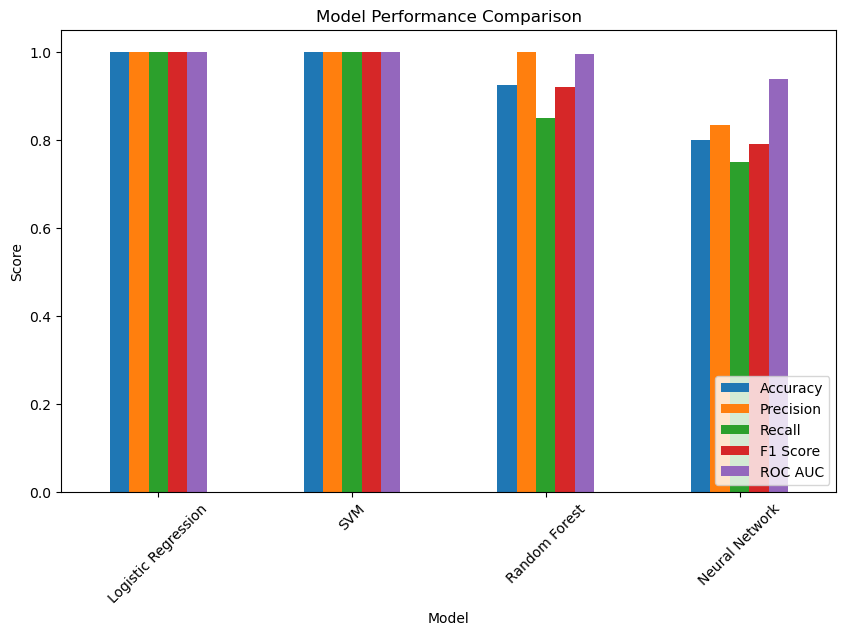

In [8]:
# comparring models

# making a DataFrame to compare the models
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)

# ploting the comparison of models
results_df.set_index('Model', inplace=True)
results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']].plot(kind='bar', figsize=(10,6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

below are made some visuals for the presentation

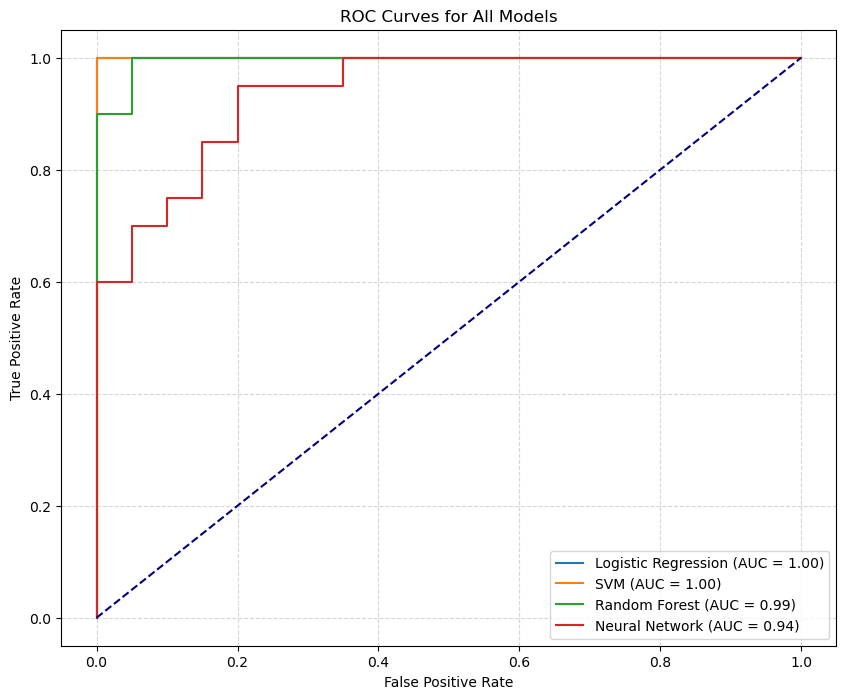

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

data = loadmat("laser.mat")
X = np.array(data['X'])
Y = np.array(data['Y']).reshape(-1)

# making a dictionary to store AUC values
auc_scores = {}

# plot ROC Curves for all models
plt.figure(figsize=(10, 8))

for model_name, model in best_estimators.items():
    
    # predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    aucc = roc_auc_score(y_test, y_proba)
    auc_scores[model_name] = aucc
    
    # plotthe ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {aucc:.2f})")

# plotting the random guess line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# labels and name
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
